# FaceMask Detection and Classification

This project will be an analysis of a dataset from Kaggle ["https://www.kaggle.com/aditya276/face-mask-dataset-yolo-format"] that gives images of people wearing (and not wearing) facemasks belonging to three classes as well as their bounding box. The goal of this project is to implement the YOLO Algorithm from 

## Libraries

In [1]:
import os
import random
import PIL
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
import csv
import cv2

## Preview Data

In [2]:
trainDir = os.path.join(os.getcwd(), "archive\\dataset\\images\\train")
validationDir = os.path.join(os.getcwd(), "archive\\dataset\\images\\valid")
testDir = os.path.join(os.getcwd(), "archive\\dataset\\images\\test")


print(f"There are {len(os.listdir(trainDir))/2} training examples")
print(f"There are {len(os.listdir(validationDir))/2} validation examples")
print(f"There are {len(os.listdir(testDir))/2} test examples")

There are 700.0 training examples
There are 100.0 validation examples
There are 120.0 test examples


In [3]:
def drawBoundingBoxes(fpath):
    """
    Take in the filepath of an image or text file, retreive the image and bounding box information, and 
    draw the bounding box over the image. Returns an image
    """ 
    
    # Reformat the filepath to incldue the path to the image and YOLO information
    fpath = os.path.splitext(fpath)[0]
    fpathImage = fpath + ".jpg"
    fpathBB = fpath + ".txt"
    
    # Retrieve the image
    try:
        image = np.array(PIL.Image.open(fpathImage))
    except FileNotFoundError:
        try:
            fpathImage =  fpath + ".jpeg"
            image = np.array(PIL.Image.open(fpathImage))
        except FileNotFoundError:
            fpathImage =  fpath + ".png"
            image = np.array(PIL.Image.open(fpathImage)) 
    
    height, width, depth = image.shape
    

    # Read in the YOLO csv file format
    classification, yMid, xMid, ylen, xlen = YOLOCSVReader(fpathBB)

    # Draw each bounding box
    for i in range(len(classification)):
            
        # Reframe YOLO format into start and end points
        xMiddle = round(width * xMid[i])
        yMiddle = round(height * yMid[i])
        xlength = round(width * xlen[i])
        ylength = round(height * ylen[i])
        
        startpoint = (xMiddle - xlength, yMiddle - ylength)
        endpoint =   (xMiddle + xlength, yMiddle + xlength)   
        
        # Color red for no mask and green for mask
        if classification[i] > 0.5:
            color = (0,255,0)
        else:
            color = (255,0,0)
        
        # Determine thickness based on image size
        longSide = np.max((width, height))
        thickness = round(longSide * 0.003)
        
        # Draw the bounding box
        image = cv2.rectangle(image, startpoint, endpoint, color, thickness)
    
    return image

def YOLOCSVReader(fpathBB):
    
    #Initialize YOLO variables
    classification = []
    yMid = []
    xMid = []
    ylen = []
    xlen = []
    
    # Open CSV File
    with open(fpathBB) as csvfile:
        
        #Format CSV file into rows
        reader = csv.reader(csvfile, delimiter=" ")
        
        #For each row, extract the required data
        for row in reader:
            classification.append(float(row[0]))
            xMid.append(float(row[1]))
            yMid.append(float(row[2]))
            xlen.append(float(row[3]))
            ylen.append(float(row[4]))
            
    return classification, yMid, xMid, ylen, xlen

def previewImage(directory=trainDir):
    """
    Preview an image within the training directory, can be applied to other images
    """
    
    # Get a List of files within the given directory
    files = os.listdir(directory)
    
    # Choose a random file
    fileName = random.sample(files, 1)[0]
    
    # Create filepath
    fpath = os.path.join(directory, fileName)
    
    # Draw bounding boxes over the image
    image = drawBoundingBoxes(fpath)
    
    plt.imshow(image)

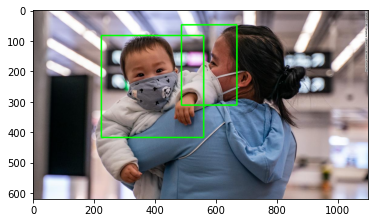

In [23]:
previewImage()

## Data Prep

Before feeding the data into TensorFlow, we need to do some prep work scripting all of the data and their labels into a dataframe. In essence, this step is compiling the outline of all the data to be used, without requiring the overhead of loading all of the data into RAM. The images will be represented by their filepath (which will account for the largest reduction), and the bounding box data will be pulled in from the CSV files.

In [151]:
def DataFrameMaker():
    
    """
    Returns: A dataframe ready for training, validation, and testing
    """
    
    # Setup the base directory and initiate pd.DataFrames
    dataDirBase = os.path.join(os.getcwd(), "archive\\dataset\\images\\")
    
    for dataType in ["train", "valid", "test"]:
        
        #Locate file directory
        dataDir = os.path.join(dataDirBase, dataType)
        files = os.listdir(dataDir)
        
        #Run through every file and store it's filepath and Bounding box info
        while len(files) > 0:
            
            #Get the first pair of image/label
            imagefName = files[0]
            textfName = files[1]
            
            #Create the filepaths
            imagefpath = os.path.join(dataDir, imagefName)
            textfpath = os.path.join(dataDir, textfName)
            
            #Start the DataFrame entry
            entry = {"FilePath":imagefpath}

            #Get the Bounding Box information
            classification, yMid, xMid, ylen, xlen = YOLOCSVReader(textfpath)
            
            #Take the first 10 Bounding boxes
            columns = ["classification", "yMid", "xMid", "ylen", "xlen"]
            columnVals =[classification, yMid, xMid, ylen, xlen]
            cutoff = len(classification)
            for i in range(10):
                for j in range(len(columns)):
                    keyName = columns[j] + str(i+1)
                    if i < cutoff:
                        entry.update({keyName:round(columnVals[j][i],2)})
                    else:
                        entry.update({keyName:None})
            
            #Make DataFrame on first path
            
            #Append entry to existing DataFrame
            if dataType == "train":
                if "trainDF" in locals():
                    trainDF = trainDF.append(entry,  ignore_index=True)
                else:
                    trainDF = pd.DataFrame(entry, index=[0])
            if dataType == "valid":
                if "validDF" in locals(): 
                    validDF = validDF.append(entry, sort=False, ignore_index=True)
                else:
                    validDF = pd.DataFrame(entry, index=[0])
            if dataType == "test":
                if "testDF" in locals(): 
                    testDF = testDF.append(entry, sort=False, ignore_index=True)
                else:
                    testDF = pd.DataFrame(entry, index=[0])
        
            
            #Remove the first file pair
            files = files[2:]

        
    return trainDF, validDF, testDF

In [152]:
trainDF, validDF, testDF = DataFrameMaker()

# Check Sizes
print(trainDF.shape)
print(validDF.shape)
print(testDF.shape)

(700, 51)
(100, 51)
(120, 51)


classification1      1.0
yMid1               0.27
xMid1               0.68
ylen1                0.3
xlen1               0.15
classification2     None
yMid2               None
xMid2               None
ylen2               None
xlen2               None
classification3     None
yMid3               None
xMid3               None
ylen3               None
xlen3               None
classification4     None
yMid4               None
xMid4               None
ylen4               None
xlen4               None
classification5     None
yMid5               None
xMid5               None
ylen5               None
xlen5               None
classification6     None
yMid6               None
xMid6               None
ylen6               None
xlen6               None
classification7     None
yMid7               None
xMid7               None
ylen7               None
xlen7               None
classification8     None
yMid8               None
xMid8               None
ylen8               None
xlen8               None


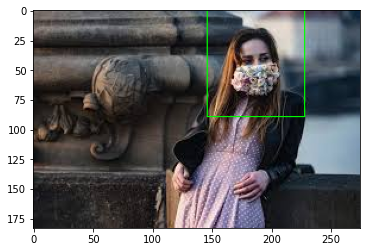

In [153]:
#Check an random training Example
training_example = random.randint(0, len(trainDF))
training_example = trainDF.iloc[training_example]
training_image = drawBoundingBoxes(training_example["FilePath"])
plt.imshow(training_image)
print(training_example[1:])


## Data Generator

For most TensorFlow implementations with images, using ImageDataGenerator is a quick and easy way to handle training data. It handles data augmentation techniques, connecting training examples to their labels, and it's a one-liner... hard to beat for the simple cases; however for implementing YOLO, the label for a given training example isn't simply defined as the file's location. Rather, there is a seperate text file that includes the YOLO format of bounding box. To coordinate the connection of training examples and their labels, we will need to implement a custom data generator.

In [155]:
#Get column Names of outputs
DFCols = trainDF.columns
XCol   = DFCols[0]
yCols  = DFCols[1:]


#Define Image size and shape
target_size   = (250,250)
target_shape = (250,250,3)

#Setup an ImageDataGenerator for our training, validation, and test sets
trainDatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
trainGenerator = trainDatagen.flow_from_dataframe(dataframe=trainDF,
                                                 x_col=XCol,
                                                 y_col=yCols,
                                                 batch_size=16,
                                                 class_mode="raw",
                                                 shuffle=True,
                                                 color_mode = "rgb",
                                                 target_size=target_size)

validDatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
validGenerator = validDatagen.flow_from_dataframe(dataframe=validDF,
                                                 x_col=XCol,
                                                 y_col=yCols,
                                                 batch_size=16,
                                                 class_mode="raw",
                                                 shuffle=True,
                                                 color_mode = "rgb",
                                                 target_size=target_size)

testDatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
testGenerator = testDatagen.flow_from_dataframe(dataframe=testDF,
                                                 x_col=XCol,
                                                 y_col=yCols,
                                                 batch_size=16,
                                                 class_mode="raw",
                                                 shuffle=True,
                                                 color_mode = "rgb",
                                                 target_size=target_size)

trainGenerator._targets = np.stack(trainGenerator._targets)
validGenerator._targets = np.stack(validGenerator._targets)

Found 700 validated image filenames.
Found 100 validated image filenames.
Found 120 validated image filenames.


(16, 250, 250, 3)
(16, 50)
[1.0 0.35 0.26 0.36 0.15 None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None]


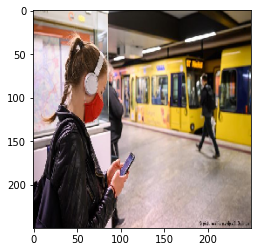

In [156]:
#Check dimensions
X_train, y_train = next(trainGenerator)

# Looking for (16, 250, 250, 3)
print(X_train.shape)
# Looking for (16,50)
print(y_train.shape)

image_arr = X_train[0]
plt.imshow(image_arr)
print(y_train[0])

In [157]:
def buildModel(target_shape,yCols):
    
    # Load in a pretrained InceptionNetV3
    ptModel = tf.keras.applications.inception_v3.InceptionV3(include_top=False, input_shape=target_shape, weights="imagenet")
    
    # Freeze all the existing layers in the pretrained Inception Model
    for layer in ptModel.layers:
        layer.trainable = False
    
    # For our model, we will pull from an intermediate layer, "mixed7" and use that as an input into our layers
    LastLayer = ptModel.get_layer("mixed7")
    LastOutput = LastLayer.output
    
    # Reduce the output of the network with a (1,1) Convolution filter
    x = tf.keras.layers.Conv2D(1024, 1)(LastOutput)
    x = tf.keras.layers.Flatten()(x)
    
    # Add 2 FC layers with Dropout
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    
    # Add softmax output layer
    x = tf.keras.layers.Dense(len(yCols), activation ="softmax")(x)
    
    # Build the model
    model = tf.keras.Model(inputs=ptModel.inputs, outputs=x)
    
    return model    

In [158]:
model = buildModel(target_shape,yCols)
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =0.0001),
            loss='rmse')

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d_570 (Conv2D)             (None, 124, 124, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_564 (BatchN (None, 124, 124, 32) 96          conv2d_570[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, 124, 124, 32) 0           batch_normalization_564[0][0]    
____________________________________________________________________________________________

In [150]:
history = model.fit(trainGenerator,
                        epochs = 10, steps_per_epoch = 128,
                        shuffle=True)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).